In [34]:
import librosa
import os
import numpy as np
import pandas as pd
from thinkdsp import *

PATH_TO_DATA = "public_lecture_1.tar/public_lecture_1/"
MANIFEST = "public_lecture_1.tar/public_lecture_1.csv"
folders = os.listdir(PATH_TO_DATA)

In [35]:
def get_audio_sample_rate_text(path_to_audio, path_to_text):
    try:
        X, sample_rate = librosa.load(path_to_audio,)
    except FileNotFoundError:
        return None
    with open(path_to_text, 'r', encoding="utf-8") as reader:
        text = reader.read()
    return X, sample_rate, text

In [53]:
manifest = pd.read_csv(MANIFEST)
manifest.columns = ['path_to_audio', 'path_to_text', 'len']
manifest["path_to_audio"] = "public_lecture_1.tar/" + manifest["path_to_audio"]
manifest["path_to_text"] = "public_lecture_1.tar/" + manifest["path_to_text"]
manifest.head()

,path_to_audio,path_to_text,len
0,public_lecture_1.tar/public_lecture_1/2/31/6c4...,public_lecture_1.tar/public_lecture_1/2/31/6c4...,0.966
1,public_lecture_1.tar/public_lecture_1/f/eb/078...,public_lecture_1.tar/public_lecture_1/f/eb/078...,0.969
2,public_lecture_1.tar/public_lecture_1/e/37/c40...,public_lecture_1.tar/public_lecture_1/e/37/c40...,0.990
3,public_lecture_1.tar/public_lecture_1/7/c7/bbf...,public_lecture_1.tar/public_lecture_1/7/c7/bbf...,1.000
4,public_lecture_1.tar/public_lecture_1/3/97/e44...,public_lecture_1.tar/public_lecture_1/3/97/e44...,1.000


In [54]:
manifest.count()

path_to_audio    6802
path_to_text     6802
len              6802
dtype: int64

In [55]:
dataset = pd.DataFrame()
for index, row in manifest.iterrows():
    try:
        request = get_audio_sample_rate_text(row['path_to_audio'], row['path_to_text'])
        if request != None:
            X, sr, text = request
            df = pd.DataFrame({'X' : [np.array(X)], 'sr' : sr, 'text' : text.split('\n')[0], 'path_to_audio' : row['path_to_audio'], 'path_to_text' : row['path_to_text']})
            dataset = dataset.append(df)
    except KeyboardInterrupt:
        break
dataset = dataset.reset_index()

Датафрейм 'dataset' содержит аудио сжмплы из папки "public_lecture_1/" (STT dataset), загруженные с помощью 'librosa', sample rate и транскрипции к аудио.

In [56]:
dataset.head()

,index,X,sr,text,path_to_audio,path_to_text
0,0,"[-0.006781096, 0.002923917, 0.019082092, 0.024...",22050,такого не было,public_lecture_1.tar/public_lecture_1/2/31/6c4...,public_lecture_1.tar/public_lecture_1/2/31/6c4...
1,0,"[0.0009860961, 0.0016607333, 0.0025275736, 0.0...",22050,ну там телевизор,public_lecture_1.tar/public_lecture_1/f/eb/078...,public_lecture_1.tar/public_lecture_1/f/eb/078...
2,0,"[0.0038796433, 0.0026135985, -0.001288979, -0....",22050,ещё один случай,public_lecture_1.tar/public_lecture_1/e/37/c40...,public_lecture_1.tar/public_lecture_1/e/37/c40...
3,0,"[0.019003231, 0.027242612, 0.015416117, -0.005...",22050,и понеслась,public_lecture_1.tar/public_lecture_1/7/c7/bbf...,public_lecture_1.tar/public_lecture_1/7/c7/bbf...
4,0,"[0.0026838735, 0.011850709, 0.015894761, 0.003...",22050,аплодисменты,public_lecture_1.tar/public_lecture_1/3/97/e44...,public_lecture_1.tar/public_lecture_1/3/97/e44...


In [58]:
dataset.count()

index            3142
X                3142
sr               3142
text             3142
path_to_audio    3142
path_to_text     3142
dtype: int64

## Шумы

**Шум** - сигнал, содержащий компоненты из разных частот (без гармонической структуры)



**1. Uncorrelated uniform (white) noise** - 'uniform' значит, что сигнал содержит случайные числа из равномерного распределения, т.е каждое число равновероятно. 'Uncorrelated' - значит, что числа (из аудио сигнала) независимы, т.е информация об одном значении не дат информации об остальных.

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from thinkdsp import UncorrelatedUniformNoise
from thinkdsp import decorate
np.random.seed(17)

#if not os.path.exists('thinkdsp.py'):
#    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

signal = UncorrelatedUniformNoise()
wave = signal.make_wave(duration=0.5, framerate=11025)
wave.make_audio()

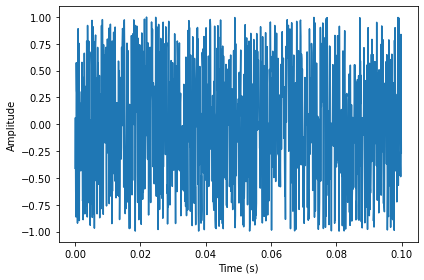

In [14]:
segment = wave.segment(duration=0.1)
segment.plot()
decorate(xlabel='Time (s)',
         ylabel='Amplitude')

График отражает пример спектрограммы UUN (Uncorrelated Uniform Noise), выглядит, достаточно, случайно, НО, нужно кое-что знать об этой рандомности:

- **Распределение:** Распределение рандомного сигнала - это значение и их вероятности. Например, в *равномерном шуме*: числа [-1, +1] и все с одинаковой вероятностью. Как альтернатива **Gaussian noise**, где числа [-inf, + inf] и числа около 0 наиболее вреоятны (с соттветствующей вероятностью).   
- **Корреляция:** В UU шуме значения независимы. Например, в **Brownian noise** каждое значения - сумма предыдущих значений с рандомным "step". Т.е если значение сигнала высокое в определенный момент времени, то мы ожидаем, что оно останется низким.
- **Взаимосвзь:** В UU шуме мощность на всех частотах берётся из одного распределения, т.е одинакова для всех частот. Например, в **Pink noise** мощность обратно пропорциональна частоте, т.е мощность на частоте *f* берется из распределения, среднее которого пропорционально *1/f*

UU-шум в среднем имеет одинаковую мощность на всех частотах, что мы можем подтвердить, посмотрев на нормализованную кумулятивную сумму мощностей, которую называют интегрированным спектром (который является функцией частоты f, который показывает совокупную мощность в спектре вплоть до f.):

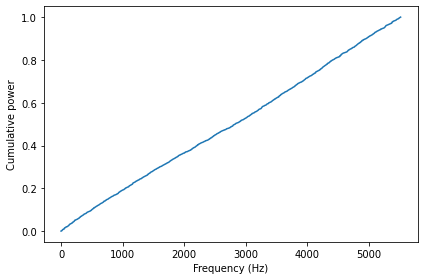

In [15]:
spectrum = wave.make_spectrum()
integ = spectrum.make_integrated_spectrum()
integ.plot_power()
decorate(xlabel='Frequency (Hz)',
         ylabel='Cumulative power')

Прямая линия на этом рисунке показывает, что шум UU в среднем имеет одинаковую мощность на всех частотах. По аналогии со светом шум с этим свойством называется «белым шумом».

Для шума UU мы можем более четко увидеть взаимосвязь между мощностью и частотой, посмотрев на интегрированный спектр, который является функцией частоты f, который показывает совокупную мощность в спектре вплоть до f.

**2. Brownian (red) noise** (по аналогии с броуновским движением): UU шум не коррелированный, т.е каждое значени не зависит от оставльных. Как альтернатива **Brownian noise:** в котором каждое значение - сумма предыдущих с некоторым шагом. 
При одномерном случайном блуждании частица перемещается вверх или вниз на случайную величину на каждом временном шаге. Местоположение частицы в любой момент времени - это сумма всех предыдущих шагов.

In [16]:
signal = BrownianNoise()
wave = signal.make_wave(duration=0.5, framerate=11025)
wave.make_audio()

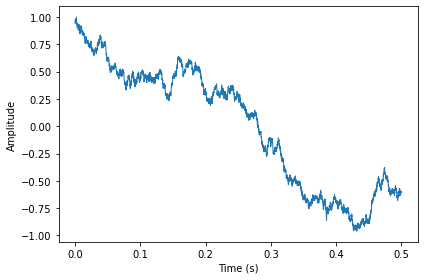

In [17]:
wave.plot(linewidth=1)
decorate(xlabel='Time (s)',
         ylabel='Amplitude')

Форма wave колеблется вверх и вниз, но между последовательными значениями существует четкая корреляция. Когда амплитуда высокая, она, как правило, остается высокой, и наоборот.

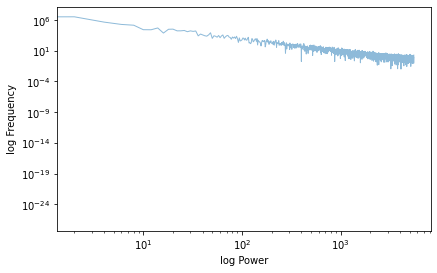

In [18]:
spectrum = wave.make_spectrum()
spectrum.plot_power(linewidth=1, alpha=0.5)
decorate(xlabel='log Power',
         ylabel='log Frequency')
plt.xscale('log')
plt.yscale('log')

Чтобы более четко увидеть форму спектра, мы можем построить график мощности и частоты в логарифмическом масштабе. Почти вся мощность приходится на самые низкие частоты; более высокочастотные компоненты не видны. Отношение между мощностью и частотой шумное, но примерно линейное.

Метод 'estimate_slop' использует SciPy для вычисления МНК для мощности спектра.

Он отбрасывает первый компонент спектра, потому что этот компонент соответствует f = 0, а log(0) не определен, 'estimate_slope' возвращает результат из scipy.stats.linregress, который является объектом, который содержит предполагаемый наклон и точку пересечения, коэффициент детерминации (R2), p-value и стандартную ошибку. Для наших целей нам понадобится только наклон.

Для **Brownian noise** наклон силы спектра = -2 (почему - написано в гл.9), можно написать соотношение:
$$log P = k - 2 log f \\ P = K/f^2$$ 
$P$ - power, $f$ - frequency, $k$ - intercept of the line(not important)

Т.е силы сигнала в **Brownian noise** пропорциональна $1/f^2$

**3. Pink noise** - обобщение **Red noise**, описывается как:
$$P = K/f^{\beta}$$

- Если $\beta = 0$, сила - константна для всех частот (**White noise**)
- Если $\beta = 2$, (**Red noise**)
- Если $\beta \in [0, 2]$ -  что-то между Red и White, это и есть **Pink noise**

Самый простой - создать белый шум, а затем применить фильтр нижних частот с желаемой экспонентой. thinkdsp предоставляет класс, представляющий сигнал розового шума:

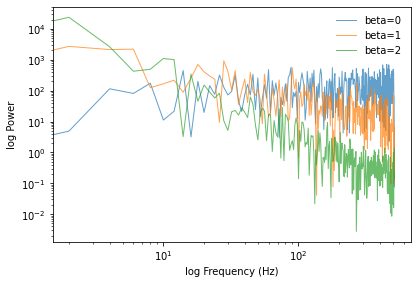

In [19]:
betas = [0, 1, 2]

for beta in betas:
    signal = PinkNoise(beta=beta)
    wave = signal.make_wave(duration=0.5, framerate=1024)
    spectrum = wave.make_spectrum()
    spectrum.hs[0] = 0
    label = f'beta={beta}'
    spectrum.plot_power(linewidth=1, alpha=0.7, label=label)
    
decorate(xlabel='log Frequency (Hz)',
         ylabel='log Power')
plt.xscale('log')
plt.yscale('log')

Иллюстрация **White, Red and pink** шумов - зависимость мощности от частоты в log шкале.

**4. Uncorrelated Gaussian (UG) noise** - Спектр в среднем имеет одинаковую мощность на всех частотах, поэтому UG также белый. И у него есть еще одно интересное свойство: спектр шума UG также является шумом UG. Точнее, действительная и мнимая части спектра - это некоррелированные гауссовы значения.

Спектр шума UU - это тоже шум UG, по крайней мере, приблизительно. Фактически, согласно центральной предельной теореме, спектр почти любого некоррелированного шума приблизительно гауссовский, если распределение имеет конечное среднее значение и стандартное отклонение, а количество отсчетов велико.

In [44]:
def read_opus(filename):
    X, sample_rate = librosa.load(filename)
    wave = Wave(X, framerate=sample_rate)

    return wave

def get_sample_manifest(dataset_, index):
    #index = np.random.randint(0, len(manifest_))
    dataset_row = dataset_.iloc[index]
    wave =  read_opus(dataset_row['path_to_audio'])
    _, _, text = get_audio_sample_rate_text(dataset_row['path_to_audio'], dataset_row['path_to_text'])
    print("text: ", text)
    return wave.make_audio()

In [59]:
get_sample_manifest(dataset, 0)

text:  такого не было



In [62]:
get_sample_manifest(dataset, 60) # в конце еще сказано слово "мы"

text:  значит слева написано



## Фильтры

**Фильтр Калмана** 
- https://www.cs.unc.edu/~welch/media/pdf/kalman_intro.pdf
- https://arxiv.org/ftp/arxiv/papers/1204/1204.0375.pdf

In [124]:
## https://scipy-cookbook.readthedocs.io/items/KalmanFiltering.html
import matplotlib.pyplot as plt
import librosa.display

def plot_melspec(z_, sr_):
    fig, ax = plt.subplots()
    S = librosa.feature.melspectrogram(y=z_, sr=sr_)
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr_,
                         fmax=8000, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram')

def kalman_filter(z_, Q=1e-4, R=None):
    """
    Parametres:
    -----------
    z : array_like audio samples
    Q : constatant, process noise covariance
    R : constatant, estimate of measurement variance 
    Returns:
    --------
    x : cleaned audio samples
    """
    ## R - выборочная дисперсия,  оценка теоретической дисперсии распределения
    if R == None:
        R = np.var(z_)
    z_shape = (len(z_), )
    
    x, P, K = np.zeros(z_shape, dtype=np.float32), np.zeros(z_shape), np.zeros(z_shape)
    
    x[0] = 0.0
    P[0] = 0.0
    
    for k in range(1, len(z_)):
        K[k] = (P[k-1] + Q) /(P[k-1] + Q + R)
        x[k] = x[k - 1] + K[k] * (z_[k] - x[k - 1])
        P[k] = (1 - K[k]) * (P[k-1] + Q)

    return x

In [125]:
index = 0
dataset_row = dataset.iloc[index]
dataset_row

index                                                            0
X                [-0.006781096, 0.002923917, 0.019082092, 0.024...
sr                                                           22050
text                                                такого не было
path_to_audio    public_lecture_1.tar/public_lecture_1/2/31/6c4...
path_to_text     public_lecture_1.tar/public_lecture_1/2/31/6c4...
Name: 0, dtype: object

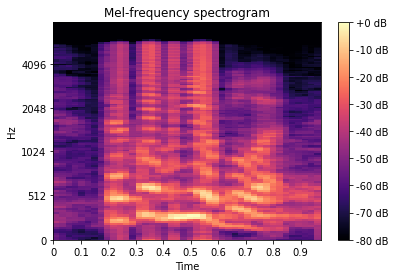

In [126]:
wave_orig = read_opus(dataset_row['path_to_audio'])
plot_melspec(wave_orig.ys, dataset_row['sr'])
wave_orig.make_audio()

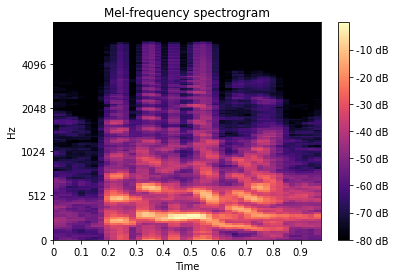

In [127]:
z = dataset_row["X"]
z_filtered = kalman_filter(z)
wave_z = Wave(z_filtered, framerate=dataset_row["sr"])
plot_melspec(wave_z.ys, dataset_row['sr'])
wave_z.make_audio()

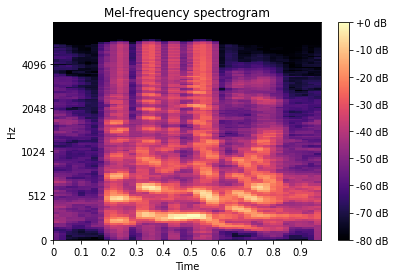

In [133]:
#sample = np.zeros((len(wave_orig.ys), ))
#sample[:5000] = wave_orig.ys[:5000]
noise = wave_orig.ys - wave_z.ys
wave_noise = Wave(noise, framerate=dataset_row["sr"])
plot_melspec(noise, dataset_row['sr'])
wave_noise.make_audio()

In [137]:
wave_orig.ys[5000:5010]

array([ 0.30414966,  0.18022019,  0.11350602,  0.07472338,  0.05240157,
        0.04699717,  0.02345772, -0.03139988, -0.09828538, -0.1874794 ],
      dtype=float32)

In [136]:
wave_z.ys[5000:5010]

array([0.05481394, 0.05944493, 0.06144129, 0.06193177, 0.06157984,
       0.06104133, 0.05965345, 0.05629104, 0.05058286, 0.04179173],
      dtype=float32)

In [135]:
noise[5000:5010]

array([ 0.2493357 ,  0.12077525,  0.05206473,  0.01279161, -0.00917827,
       -0.01404416, -0.03619573, -0.08769092, -0.14886823, -0.22927113],
      dtype=float32)